In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
import sys
# Don't generate the __pycache__ folder locally
sys.dont_write_bytecode = True 
# Print exception without the buit-in python warning
sys.tracebacklimit = 0

from modules import *

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from stardist.models import StarDist2D
model = StarDist2D.from_pretrained('2D_versatile_fluo')
from stardist import random_label_cmap
lbl_cmap = random_label_cmap()

def predict_mask_from_image_stardist(img_patch):

    """
    Predicts a segmentation mask from an image patch.

    This function takes an image patch and uses a pre-defined model
    to predict the segmentation mask. It silences any print output during the prediction 
    to keep the console clean. The function assumes that the model is already 
    loaded and available in the global scope.

    Args:
    img_patch (numpy array): The image patch for which to predict the segmentation mask.

    Returns:
    numpy array: The predicted segmentation mask, where each pixel's intensity corresponds to a label.
    """

    # Performing the prediction using the pre-defined model
    labels, details = model.predict_instances(img_patch)

    # Returning the predicted segmentation mask
    return labels.astype('uint16')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


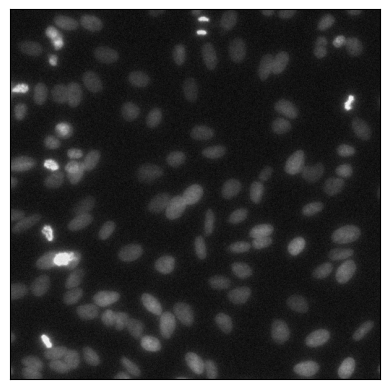

In [4]:
from stardist.data import test_image_nuclei_2d
image = test_image_nuclei_2d() 

# Show the original image
plt.imshow(image, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
img_array = np.asarray(image, dtype=np.float32)

min_val = img_array.min()
max_val = img_array.max()

if max_val - min_val > 0:
    normalized_image = (img_array - min_val) / (max_val - min_val)
else:
    raise ValueError('Image has no variance, it might be empty or corrupted')

In [6]:
window_size = 256

overlap = int(0.5 * window_size)

In [7]:
patches, window_coords = patchify(normalized_image, window_size, overlap)

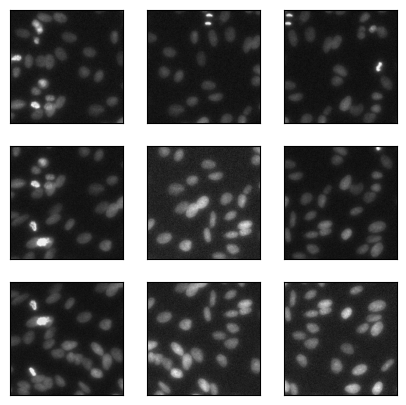

In [8]:
# View patches

num_rows = len(set(y for _, _, _, y in window_coords))
num_cols = len(set(x for x, _, _, _ in window_coords))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 5))

for ax, patch in zip(axs.ravel(), patches):
    ax.imshow(patch, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Save the figure
plt.show()

In [ ]:
predicted_labels = []
for patch in tqdm(patches, desc='Predicting on patches'):
    label = predict_mask_from_image_stardist(patch)
    predicted_labels.append(label)

predicted_labels = np.array(predicted_labels)

Predicting on patches:   0%|          | 0/9 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


In [ ]:
border_cleaned_predicted_labels = []

for patch, patch_coords in zip(predicted_labels, window_coords):
    cleaned_patch = remove_border_labels(patch, patch_coords, normalized_image)
    border_cleaned_predicted_labels.append(cleaned_patch)

In [ ]:
# View predicted patches

num_rows = len(set(y for _, _, _, y in window_coords))
num_cols = len(set(x for x, _, _, _ in window_coords))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 5))

for ax, patch in zip(axs.ravel(), border_cleaned_predicted_labels):
    ax.imshow(patch, cmap=lbl_cmap)
    ax.set_xticks([])
    ax.set_yticks([])

# Save the figure
plt.show()

In [ ]:
region_info_list = generate_bbox_list(window_coords, border_cleaned_predicted_labels, min_area_threshold = 10)

In [ ]:
nms_region_info_list = nms_without_scores(region_info_list)

In [ ]:
reconstructed_image = reconstruct_patches(nms_region_info_list)

In [ ]:
 # Visualization
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].imshow(normalized_image, cmap='gray', alpha = 1)
axes[0].set_title('Image')
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(reconstructed_image, cmap=lbl_cmap, alpha = 1)
axes[1].set_title('Mask')
axes[1].set_xticks([])
axes[1].set_yticks([])

mask_float = np.float32(reconstructed_image)
mask_float[mask_float == 0] = np.nan
axes[2].imshow(normalized_image, cmap='gray', alpha = 1)
axes[2].imshow(mask_float, cmap=lbl_cmap, alpha = 0.5)
axes[2].set_title('Overlay')
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()